In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import norm
from tqdm import trange, tqdm_notebook, tqdm

import math

from collections import OrderedDict


import scanpy as sc
import os
import copy

EPS = 1e-3


In [2]:
## Load adipose data
UCE_filtered_DIR = '/home/syyang/GitRepo/cs294/finalproject/data/UCEgenes_anndata'

adipose_sn_file = 'adata_with_infer_multiresleiden_toR_Xastypeinteger_proc.h5ad'
adipose_sn_ad = sc.read_h5ad(os.path.join(UCE_filtered_DIR,  adipose_sn_file) )

adipose_sn_ad.obs['sample'] = adipose_sn_ad.obs['sample'].astype('category')
adipose_sn_ad.obs['leiden_scVI_res0.9'] = adipose_sn_ad.obs['leiden_scVI_res0.9'].astype('category')

In [3]:
class scDataset(Dataset):
    def __init__(self, adata):
        """
        adata: AnnData object
        cat: from adata.obs['sample']
        labels: from adata.obs['leiden_scVI_res0.9'] --> Need to be changed to cell type
        """
        self.obs = adata.obs
        self.data = torch.log(torch.tensor(adata.layers['counts'].toarray() + 1. ))  # log transform
        #self.data =  torch.tensor(adata.layers['counts'].toarray())
        self.local_library_mean = self.data.sum(axis=1)
        self.local_library_var = torch.tensor([1.])
        
        self.cat = torch.tensor(adata.obs['sample'].cat.codes.values).to(torch.int64) # sample labels
        self.n_cat = adata.obs['sample'].nunique()
        self.labels = torch.tensor(adata.obs['leiden_scVI_res0.9'].cat.codes.values).to(torch.int64)   # cell type labels
        self.n_labels = adata.obs['leiden_scVI_res0.9'].nunique()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # onehot encode `cat` and `labels`
        cat_onehot = F.one_hot(self.cat[idx], self.n_cat)
        label_onehot = F.one_hot(self.labels[idx], self.n_labels)
        
        return self.data[idx], cat_onehot, label_onehot, self.local_library_mean[idx], self.local_library_var 
    

# Example
# adipose_dataset = scDataset(adipose_sn_ad)
# data_loader = DataLoader(adipose_dataset, batch_size=10, shuffle=False)
# a = next(iter(data_loader))
    

In [4]:
class LinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.1):
        super(LinearBlock, self).__init__()
        layers = [
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim, momentum=.01, eps=0.001),
            nn.ReLU(),
        ]
        if dropout:
            layers.append(nn.Dropout(p=dropout))
            
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

class Encoder_x(nn.Module):
    """_summary_
        This encodes the latent space of the data vector x
    Args:
        nn (_type_): _description_
        latent_dim: 1280, same as the latent_dim in the UCE model (UCE: \ref[Rosen, Yanay, et al. "Universal Cell Embeddings: A Foundation Model for Cell Biology." bioRxiv (2023): 2023-11.])
        
    """
    def __init__(self, input_dim, latent_dim=1280, hidden_dim=1280, hidden_layers=1):
        super(Encoder_x, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -2) + [[hidden_dim, latent_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        self.linear_mean = nn.Linear(latent_dim, latent_dim)
        self.linear_var = nn.Linear(latent_dim, latent_dim)

    def forward(self, x, cell_type_one_hot=None):
        if cell_type_one_hot is not None:
            x = torch.cat([x, cell_type_one_hot], dim=1) # cell_type_one_hot is the one_hot encoded cell_type_index  
        x = self.layers(x)
        qz_mean = self.linear_mean(x)
        qz_var = torch.exp(self.linear_var(x))
        #z_dist = torch.distributions.Normal(qz_mean, qz_var.sqrt())
        return qz_mean, qz_var #, z_dist
    
    
class Encoder_l(nn.Module):
    """_summary_
        This encodes the library size, which is affected by observation x 
        
    Args:
        nn (_type_): _description_
        latent_dim: 1
        
    """
    def __init__(self, input_dim, latent_dim=1, hidden_dim=20, hidden_layers=1):
        super(Encoder_l, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -2) + [[hidden_dim, latent_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        self.linear_mean = nn.Linear(latent_dim, latent_dim)
        self.linear_var = nn.Linear(latent_dim, latent_dim)

    def forward(self, x):
        x = self.layers(x)
        ql_mean = self.linear_mean(x)
        ql_var = torch.exp(self.linear_var(x))
        #library_dist = torch.distributions.Normal(ql_mean, ql_var.sqrt())
        return ql_mean, ql_var #, library_dist
    

    
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=1280, hidden_layers=1):
        super(Decoder, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -1) 
        self.decoder = nn.Sequential(
            *[LinearBlock(dim[0], dim[1], dropout=None) for dim in layer_dims]
        )
        
        self.px_dropout_decoder = nn.Linear(hidden_dim, output_dim)  # the logit of the dropout rate
        self.px_scale_decoder = nn.Sequential(nn.Linear(hidden_dim, output_dim),
                                      nn.Softmax(dim=-1))
        self.px_dispersion_decoder = nn.Linear(hidden_dim, output_dim)
        

    def forward(self, z, library, cat_one_hot):
        
        input = torch.cat([z, cat_one_hot], dim=1) # cat_index is the one_hot encoded cell_type_index
        x = self.decoder(input)
        
        px_scale = self.px_scale_decoder(x)
        #px_rate = torch.exp(library) * px_scale  # encode library size
        px_rate = library * px_scale  # use observed library size

        
        px_dispersion = self.px_dispersion_decoder(x)
        px_dropout = self.px_dropout_decoder(x)
        
        #px_dispersion = torch.clamp(torch.exp(px_dispersion), min=EPS)  # Clipping at the minimum does not seem to solve the NAN problem in lgammaBACK0
        px_dispersion = torch.exp(px_dispersion)  # positive value
        
        
        
        return px_rate, px_dispersion, px_dropout 
    
    

    
def log_zinb_positive(
    x: torch.Tensor,
    mu: torch.Tensor,
    theta: torch.Tensor,
    pi: torch.Tensor,
    eps: float = 1e-8,
) -> torch.Tensor:
    """
    Adapted From `https://github.com/scverse/scvi-tools`  with minor modifications
     
    Log likelihood (scalar) of a minibatch according to a zinb model.

    Parameters
    ----------
    x
        Data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    pi
        logit of the dropout parameter (real support) (shape: minibatch x vars)
    eps
        numerical stability constant

    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """
    # theta is the dispersion rate. If .ndimension() == 1, it is shared for all cells (regardless
    # of batch or labels)
    if theta.ndimension() == 1:
        theta = theta.view(1, theta.size(0))  # In this case, we reshape theta for broadcasting

    # Uses log(sigmoid(x)) = -softplus(-x)
    softplus_pi = F.softplus(-pi)
    log_theta_eps = torch.log(theta + eps)
    log_theta_mu_eps = torch.log(theta + mu + eps)
    pi_theta_log = -pi + theta * (log_theta_eps - log_theta_mu_eps)

    case_zero = F.softplus(pi_theta_log) - softplus_pi
    mul_case_zero = torch.mul((x < eps).type(torch.float32), case_zero)

    case_non_zero = (
        -softplus_pi
        + pi_theta_log
        + x * (torch.log(mu + eps) - log_theta_mu_eps)
        + torch.lgamma(x + theta)
        - torch.lgamma(theta)
        - torch.lgamma(x + 1)
    )
    mul_case_non_zero = torch.mul((x > eps).type(torch.float32), case_non_zero)
    

    # print(f"x[0, 0] is: {x[0,0]}")
    # print(f"torch.lgamma(x + theta)[0, 0] is: {torch.lgamma(x + theta)[0,0]}")
    # print(f"torch.lgamma(theta)[0, 0] is: {torch.lgamma(theta)[0,0]}")

    res = mul_case_zero + mul_case_non_zero

    return res



In [5]:
class snRNAseqVAE(nn.Module):
    def __init__(self, input_dim, output_dim, latent_dim, encode_hidden_dim, decode_hidden_dim, total_cat, total_cell_type, cell_type_encode=True):
        super(snRNAseqVAE, self).__init__()

        self.cell_type_encode = cell_type_encode 
        
        self.total_cat = total_cat
        self.total_cell_type = total_cell_type # total_cell_type = total-known-cell-types + 1 (for unknown cell type: 0) 
                
        if cell_type_encode:
            encoder_x_input_dim = input_dim + total_cell_type
        else:
            encoder_x_input_dim = input_dim
        self.encoder_x = Encoder_x(encoder_x_input_dim, latent_dim, hidden_dim=encode_hidden_dim,  hidden_layers=1)
        
        #self.encoder_l = Encoder_l(input_dim, 1)
        
        decoder_input_dim = latent_dim + total_cat  # total_cat is the total number of categories in the cat_index, indicates datasets 
        self.decoder = Decoder(decoder_input_dim, output_dim, hidden_dim=decode_hidden_dim, hidden_layers=1)
        
    def _inference(self, x, cat_one_hot, cell_type_one_hot, l):
        if self.cell_type_encode:
            qz_mean, qz_var = self.encoder_x(x, cell_type_one_hot)
        else:
            qz_mean, qz_var = self.encoder_x(x)
        #ql_mean, ql_var = self.encoder_l(x)
        z = torch.distributions.Normal(qz_mean, qz_var.sqrt()).rsample()
        #l = torch.distributions.Normal(ql_mean, ql_var.sqrt()).rsample()
        px_rate, px_dispersion, px_dropout  = self.decoder(z, l, cat_one_hot)
        #return qz_mean, qz_var, ql_mean, ql_var, px_rate, px_dispersion, px_dropout  # encode library size 
        return qz_mean, qz_var, px_rate, px_dispersion, px_dropout 
    
    
    def forward(self, x, local_l_mean, local_l_var, cat_one_hot, cell_type_one_hot):
        """_summary_

        Args:
            x (_type_): _description_
            local_l_mean (_type_): shape of [batch_size, 1]
            local_l_var (_type_): shape of [batch_size, 1]
            cat_one_hot (_type_): shape of [batch_size, n_cat]
            cell_type_one_hot (_type_): shape of [batch_size, n_cell_types]

        Returns:
            _type_: _description_
        """
        #local_l_mean =  x.sum(axis=1) outside of this function
        #local_l_var = 0 # should this be within batch? YES as it is observed and varies from batch to batch. FInish outside of this function

        
        #qz_mean, qz_var, ql_mean, ql_var, px_rate, px_dispersion, px_dropout = self._inference(x, cat_one_hot, cell_type_one_hot, local_l_mean)  # encode library size output 
        qz_mean, qz_var, px_rate, px_dispersion, px_dropout = self._inference(x, cat_one_hot, cell_type_one_hot, local_l_mean)
        z_dist = torch.distributions.Normal(qz_mean, qz_var.sqrt())
        #l_dist = torch.distributions.Normal(ql_mean, ql_var)

        kl_z = torch.distributions.kl.kl_divergence(z_dist, torch.distributions.Normal(torch.zeros_like(qz_mean), torch.ones_like(qz_var))).sum(axis=1)
        #kl_l = torch.distributions.kl.kl_divergence(l_dist, torch.distributions.Normal(local_l_mean, local_l_var.sqrt())).sum(axis=1)
        
        reconst_loss = -log_zinb_positive(x, px_rate, px_dispersion, px_dropout).sum(axis=-1)

        return (reconst_loss + kl_z ).mean() #, reconst_loss.mean(), kl_z.mean(), kl_l.mean()
        #return (reconst_loss + kl_z ).mean()

In [32]:
## Training 
def trainning(model, scheduler, train_loader, device, optimizer, n_epochs=100, detect_anomaly=False):
    model = model.to(device)
    model.train()
    train_loss = []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_loss = 0
        N = 0
        for i, data in enumerate(train_loader):
            x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
            
            x = x.to(device)
            cat_onehot = cat_onehot.to(device)
            label_onehot = label_onehot.to(device)
            local_library_mean = local_library_mean.to(device).view((-1,1))  # size of [batch_size, 1]
            local_library_var = local_library_var.to(device).view((-1,1))  # size of [batch_size, 1]
            
            optimizer.zero_grad()
            loss = model(x, local_library_mean, local_library_var, cat_onehot, label_onehot) 
            if detect_anomaly:
                with torch.autograd.detect_anomaly():
                    loss.backward()
            else:
                loss.backward()
            #loss.backward()
            total_loss += loss.item() * x.size(0)
            N += x.size(0)
            optimizer.step()
        scheduler.step(loss)
        print("Epoch: ", epoch, "Loss: ", total_loss/N )
        train_loss.append(total_loss/N)
        
    return train_loss, loss

In [33]:
## Data
train_data = adipose_sn_ad#[adipose_sn_ad.obs['sample'] == '03_SQ', ]
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=1000, shuffle=True)

## set model 
total_cat = adipose_dataset.obs['sample'].nunique()
total_cell_type = adipose_dataset.obs['leiden_scVI_res0.9'].nunique()
output_dim  = adipose_dataset.data.shape[1]
model = snRNAseqVAE(input_dim=adipose_dataset.data.shape[1], output_dim=output_dim, \
    latent_dim=1280, encode_hidden_dim=1280, decode_hidden_dim=1280, total_cat=total_cat, total_cell_type=total_cell_type, cell_type_encode=False)

optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=0.01, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

train_loss, _ = trainning(model, scheduler, data_loader, device='cuda', optimizer=optimizer, n_epochs=100)

  1%|          | 1/100 [00:05<08:32,  5.18s/it]

Epoch:  0 Loss:  3258.73869409454


  2%|▏         | 2/100 [00:10<08:15,  5.05s/it]

Epoch:  1 Loss:  3044.473222711113


  3%|▎         | 3/100 [00:15<08:07,  5.02s/it]

Epoch:  2 Loss:  3013.3098665730336


  4%|▍         | 4/100 [00:19<07:53,  4.93s/it]

Epoch:  3 Loss:  2997.3381759129215


  5%|▌         | 5/100 [00:24<07:51,  4.96s/it]

Epoch:  4 Loss:  2986.5960220165466


  6%|▌         | 6/100 [00:29<07:44,  4.94s/it]

Epoch:  5 Loss:  2977.602191367846


  7%|▋         | 7/100 [00:34<07:38,  4.94s/it]

Epoch:  6 Loss:  2971.1669338954966


  8%|▊         | 8/100 [00:39<07:34,  4.94s/it]

Epoch:  7 Loss:  2965.855191691538


  9%|▉         | 9/100 [00:44<07:30,  4.95s/it]

Epoch:  8 Loss:  2960.951180104459


 10%|█         | 10/100 [00:49<07:26,  4.96s/it]

Epoch:  9 Loss:  2957.016123568074


 11%|█         | 11/100 [00:54<07:21,  4.96s/it]

Epoch:  10 Loss:  2952.489577389835


 12%|█▏        | 12/100 [00:59<07:18,  4.98s/it]

Epoch:  11 Loss:  2946.94825796063


 13%|█▎        | 13/100 [01:04<07:11,  4.96s/it]

Epoch:  12 Loss:  2941.2957263046437


 14%|█▍        | 14/100 [01:09<07:06,  4.95s/it]

Epoch:  13 Loss:  2935.6083998090767


 15%|█▌        | 15/100 [01:14<07:00,  4.95s/it]

Epoch:  14 Loss:  2930.1558440133426


 16%|█▌        | 16/100 [01:19<06:56,  4.96s/it]

Epoch:  15 Loss:  2925.311427427142


 17%|█▋        | 17/100 [01:24<06:52,  4.97s/it]

Epoch:  16 Loss:  2921.5887458029756


 18%|█▊        | 18/100 [01:29<06:48,  4.98s/it]

Epoch:  17 Loss:  2918.399916745304


 19%|█▉        | 19/100 [01:34<06:43,  4.98s/it]

Epoch:  18 Loss:  2915.5469662098403


 20%|██        | 20/100 [01:39<06:38,  4.98s/it]

Epoch:  19 Loss:  2913.0745877040904


 21%|██        | 21/100 [01:44<06:33,  4.98s/it]

Epoch:  20 Loss:  2911.067918413141


 22%|██▏       | 22/100 [01:49<06:28,  4.99s/it]

Epoch:  21 Loss:  2909.07127328937


 23%|██▎       | 23/100 [01:54<06:24,  4.99s/it]

Epoch:  22 Loss:  2906.9991681388256


 24%|██▍       | 24/100 [01:59<06:19,  4.99s/it]

Epoch:  23 Loss:  2905.385933522428


 25%|██▌       | 25/100 [02:04<06:14,  4.99s/it]

Epoch:  24 Loss:  2903.757333819786


 26%|██▌       | 26/100 [02:09<06:05,  4.94s/it]

Epoch:  25 Loss:  2902.1699383339187


 27%|██▋       | 27/100 [02:14<06:01,  4.96s/it]

Epoch:  26 Loss:  2900.7139357663273


 28%|██▊       | 28/100 [02:19<05:58,  4.98s/it]

Epoch:  27 Loss:  2899.437434850114


 29%|██▉       | 29/100 [02:24<05:53,  4.97s/it]

Epoch:  28 Loss:  2898.2427525895364


 30%|███       | 30/100 [02:29<05:47,  4.96s/it]

Epoch:  29 Loss:  2897.1709423279494


 31%|███       | 31/100 [02:34<05:42,  4.96s/it]

Epoch:  30 Loss:  2896.5112825886586


 32%|███▏      | 32/100 [02:39<05:37,  4.96s/it]

Epoch:  31 Loss:  2895.650697172358


 33%|███▎      | 33/100 [02:43<05:31,  4.95s/it]

Epoch:  32 Loss:  2895.121338576413


 34%|███▍      | 34/100 [02:48<05:27,  4.96s/it]

Epoch:  33 Loss:  2894.594869892249


 35%|███▌      | 35/100 [02:53<05:22,  4.96s/it]

Epoch:  34 Loss:  2893.8230247926176


 36%|███▌      | 36/100 [02:58<05:17,  4.96s/it]

Epoch:  35 Loss:  2893.4189096515097


 37%|███▋      | 37/100 [03:03<05:13,  4.97s/it]

Epoch:  36 Loss:  2893.0191115475773


 38%|███▊      | 38/100 [03:08<05:08,  4.97s/it]

Epoch:  37 Loss:  2884.0735953684602


 39%|███▉      | 39/100 [03:13<05:03,  4.98s/it]

Epoch:  38 Loss:  2881.207305565309


 40%|████      | 40/100 [03:18<04:58,  4.97s/it]

Epoch:  39 Loss:  2880.298649134261


 41%|████      | 41/100 [03:23<04:53,  4.97s/it]

Epoch:  40 Loss:  2879.6470240903705


 42%|████▏     | 42/100 [03:28<04:48,  4.97s/it]

Epoch:  41 Loss:  2879.2320577214273


 43%|████▎     | 43/100 [03:33<04:43,  4.97s/it]

Epoch:  42 Loss:  2878.799174448078


 44%|████▍     | 44/100 [03:38<04:35,  4.93s/it]

Epoch:  43 Loss:  2878.522624840897


 45%|████▌     | 45/100 [03:43<04:31,  4.94s/it]

Epoch:  44 Loss:  2878.251157610604


 46%|████▌     | 46/100 [03:48<04:27,  4.95s/it]

Epoch:  45 Loss:  2877.976970544022


 47%|████▋     | 47/100 [03:53<04:22,  4.96s/it]

Epoch:  46 Loss:  2877.674454935481


 48%|████▊     | 48/100 [03:58<04:17,  4.96s/it]

Epoch:  47 Loss:  2877.449447117495


 49%|████▉     | 49/100 [04:03<04:12,  4.96s/it]

Epoch:  48 Loss:  2876.401633959138


 50%|█████     | 50/100 [04:08<04:08,  4.96s/it]

Epoch:  49 Loss:  2876.219452247191


 51%|█████     | 51/100 [04:13<04:03,  4.96s/it]

Epoch:  50 Loss:  2876.0803613555563


 52%|█████▏    | 52/100 [04:18<03:58,  4.96s/it]

Epoch:  51 Loss:  2876.058641755179


 53%|█████▎    | 53/100 [04:23<03:53,  4.96s/it]

Epoch:  52 Loss:  2875.973277574175


 54%|█████▍    | 54/100 [04:28<03:48,  4.96s/it]

Epoch:  53 Loss:  2875.9962473665732


 55%|█████▌    | 55/100 [04:33<03:43,  4.96s/it]

Epoch:  54 Loss:  2875.909529439519


 56%|█████▌    | 56/100 [04:38<03:38,  4.96s/it]

Epoch:  55 Loss:  2875.887521122279


 57%|█████▋    | 57/100 [04:43<03:33,  4.96s/it]

Epoch:  56 Loss:  2875.8650492121665


 58%|█████▊    | 58/100 [04:48<03:28,  4.96s/it]

Epoch:  57 Loss:  2875.8653790763256


 59%|█████▉    | 59/100 [04:52<03:23,  4.97s/it]

Epoch:  58 Loss:  2875.8183429160813


 60%|██████    | 60/100 [04:57<03:18,  4.97s/it]

Epoch:  59 Loss:  2875.6279646627017


 61%|██████    | 61/100 [05:02<03:13,  4.97s/it]

Epoch:  60 Loss:  2875.6282609232358


 62%|██████▏   | 62/100 [05:07<03:06,  4.92s/it]

Epoch:  61 Loss:  2875.6485801439608


 63%|██████▎   | 63/100 [05:12<03:02,  4.93s/it]

Epoch:  62 Loss:  2875.6053288491926


 64%|██████▍   | 64/100 [05:17<02:57,  4.94s/it]

Epoch:  63 Loss:  2875.6128841785903


 65%|██████▌   | 65/100 [05:22<02:53,  4.95s/it]

Epoch:  64 Loss:  2875.612400697858


 66%|██████▌   | 66/100 [05:27<02:48,  4.95s/it]

Epoch:  65 Loss:  2875.568266107795


 67%|██████▋   | 67/100 [05:32<02:43,  4.95s/it]

Epoch:  66 Loss:  2875.5670323746926


 68%|██████▊   | 68/100 [05:37<02:38,  4.95s/it]

Epoch:  67 Loss:  2875.583977517117


 69%|██████▉   | 69/100 [05:42<02:33,  4.95s/it]

Epoch:  68 Loss:  2875.6080095955494


 70%|███████   | 70/100 [05:47<02:28,  4.95s/it]

Epoch:  69 Loss:  2875.5308844748506


 71%|███████   | 71/100 [05:52<02:23,  4.95s/it]

Epoch:  70 Loss:  2875.566871900237


 72%|███████▏  | 72/100 [05:57<02:18,  4.95s/it]

Epoch:  71 Loss:  2875.5993384886324


 73%|███████▎  | 73/100 [06:02<02:13,  4.95s/it]

Epoch:  72 Loss:  2875.5997341884654


 74%|███████▍  | 74/100 [06:07<02:08,  4.95s/it]

Epoch:  73 Loss:  2875.6061799124386


 75%|███████▌  | 75/100 [06:12<02:03,  4.96s/it]

Epoch:  74 Loss:  2875.5604014878863


 76%|███████▌  | 76/100 [06:17<01:58,  4.95s/it]

Epoch:  75 Loss:  2875.5850500899755


 77%|███████▋  | 77/100 [06:22<01:53,  4.95s/it]

Epoch:  76 Loss:  2875.5705024633517


 78%|███████▊  | 78/100 [06:26<01:48,  4.95s/it]

Epoch:  77 Loss:  2875.5330385358147


 79%|███████▉  | 79/100 [06:31<01:43,  4.95s/it]

Epoch:  78 Loss:  2875.5888075239204


 80%|████████  | 80/100 [06:36<01:38,  4.90s/it]

Epoch:  79 Loss:  2875.5791070488062


 81%|████████  | 81/100 [06:41<01:33,  4.92s/it]

Epoch:  80 Loss:  2875.5548980369995


 82%|████████▏ | 82/100 [06:46<01:28,  4.93s/it]

Epoch:  81 Loss:  2875.5520588735517


 83%|████████▎ | 83/100 [06:51<01:23,  4.93s/it]

Epoch:  82 Loss:  2875.5770393971648


 84%|████████▍ | 84/100 [06:56<01:19,  4.94s/it]

Epoch:  83 Loss:  2875.5251094518085


 85%|████████▌ | 85/100 [07:01<01:14,  4.94s/it]

Epoch:  84 Loss:  2875.5389651180653


 86%|████████▌ | 86/100 [07:06<01:09,  4.95s/it]

Epoch:  85 Loss:  2875.556002841907


 87%|████████▋ | 87/100 [07:11<01:04,  4.95s/it]

Epoch:  86 Loss:  2875.5392243460324


 88%|████████▊ | 88/100 [07:16<00:59,  4.95s/it]

Epoch:  87 Loss:  2875.5760566625704


 89%|████████▉ | 89/100 [07:21<00:54,  4.95s/it]

Epoch:  88 Loss:  2875.5656848007375


 90%|█████████ | 90/100 [07:26<00:49,  4.95s/it]

Epoch:  89 Loss:  2875.5660249517205


 91%|█████████ | 91/100 [07:31<00:44,  4.95s/it]

Epoch:  90 Loss:  2875.524657517337


 92%|█████████▏| 92/100 [07:36<00:39,  4.95s/it]

Epoch:  91 Loss:  2875.5476821727966


 93%|█████████▎| 93/100 [07:41<00:34,  4.95s/it]

Epoch:  92 Loss:  2875.5320619733147


 94%|█████████▍| 94/100 [07:46<00:29,  4.95s/it]

Epoch:  93 Loss:  2875.5723479195926


 95%|█████████▌| 95/100 [07:50<00:24,  4.95s/it]

Epoch:  94 Loss:  2875.5496195246665


 96%|█████████▌| 96/100 [07:55<00:19,  4.96s/it]

Epoch:  95 Loss:  2875.5824043188204


 97%|█████████▋| 97/100 [08:00<00:14,  4.95s/it]

Epoch:  96 Loss:  2875.5105570246665


 98%|█████████▊| 98/100 [08:05<00:09,  4.89s/it]

Epoch:  97 Loss:  2875.5415388814517


 99%|█████████▉| 99/100 [08:10<00:04,  4.91s/it]

Epoch:  98 Loss:  2875.5317574833216


100%|██████████| 100/100 [08:15<00:00,  4.96s/it]

Epoch:  99 Loss:  2875.56711672665


In [35]:
#model = torch.load('/home/syyang/GitRepo/yyyyvae/script/model_44epo_20240430.pth')
_, loss = trainning(model, scheduler, data_loader, device='cuda', optimizer=optimizer, n_epochs=10, detect_anomaly=True)

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_222288/173192725.py:22: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():
 10%|█         | 1/10 [00:05<00:50,  5.63s/it]

Epoch:  0 Loss:  2875.5406747882284


 20%|██        | 2/10 [00:11<00:43,  5.48s/it]

Epoch:  1 Loss:  2875.547499067328


 30%|███       | 3/10 [00:16<00:38,  5.43s/it]

Epoch:  2 Loss:  2875.551363484243


 40%|████      | 4/10 [00:21<00:32,  5.42s/it]

Epoch:  3 Loss:  2875.55329397823


 50%|█████     | 5/10 [00:27<00:27,  5.42s/it]

Epoch:  4 Loss:  2875.5440598391415


 60%|██████    | 6/10 [00:32<00:21,  5.41s/it]

Epoch:  5 Loss:  2875.533967778924


 70%|███████   | 7/10 [00:37<00:16,  5.40s/it]

Epoch:  6 Loss:  2875.5893870150107


 80%|████████  | 8/10 [00:43<00:10,  5.40s/it]

Epoch:  7 Loss:  2875.5592095878687


 90%|█████████ | 9/10 [00:48<00:05,  5.39s/it]

Epoch:  8 Loss:  2875.534670711903


100%|██████████| 10/10 [00:54<00:00,  5.42s/it]

Epoch:  9 Loss:  2875.560851364993


In [20]:
# model_44epo = copy.deepcopy(model)
# torch.save(model, '/home/syyang/GitRepo/yyyyvae/script/model_44epo_20240430.pth')

In [36]:
# Get latent representation of the data
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=1000, shuffle=False)
z = []
model.eval()
with torch.no_grad():
    for i, data in enumerate(data_loader):
        x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
        x = x.to('cuda')
        cat_onehot = cat_onehot.to('cuda')
        label_onehot = label_onehot.to('cuda')
        local_library_mean = local_library_mean.to('cuda').view((-1,1))
        local_library_var = local_library_var.to('cuda').view((-1,1))
        #qz_mean, _ = model.encoder_x(x, label_onehot)
        qz_mean, _ = model.encoder_x(x)
        z.append(qz_mean.cpu().detach())

In [37]:
train_data_2 = train_data.copy()
train_data_2.obsm['syy_VAE'] = torch.cat(z).numpy()
sc.pp.neighbors(train_data_2, use_rep='syy_VAE')
sc.tl.umap(train_data_2)


train_data_2.obsm['syy_VAE'].shape

(71200, 1280)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


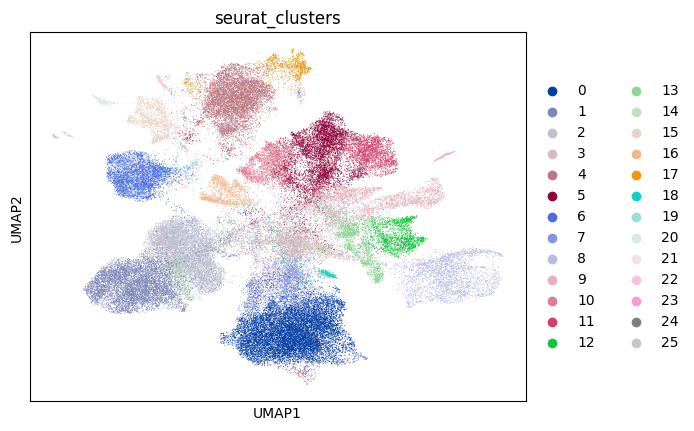

In [38]:
sc.pl.umap(train_data_2, color=['seurat_clusters'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


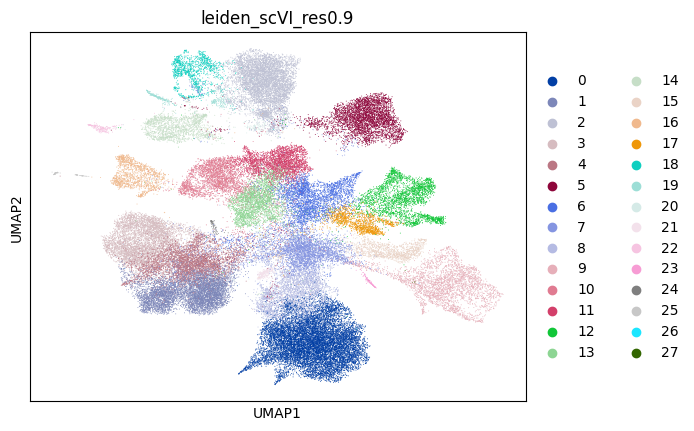

In [13]:
sc.pl.umap(train_data_2, color=['leiden_scVI_res0.9'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


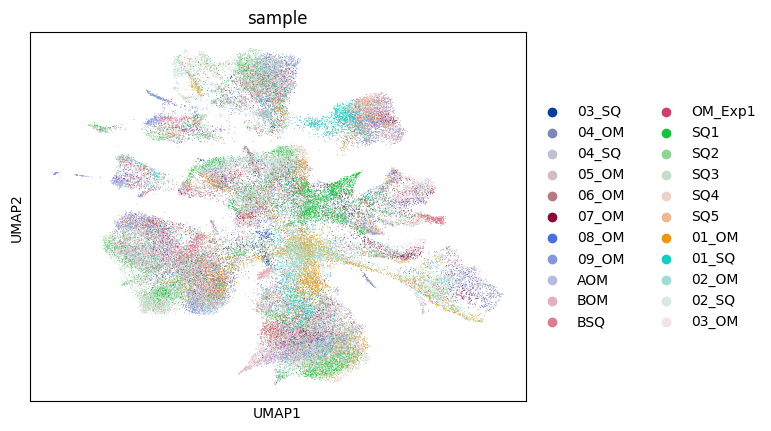

In [14]:
sc.pl.umap(train_data_2, color=['sample'] )

In [32]:
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=1000, shuffle=False)
z = []
model.eval()
with torch.no_grad():
    for i, data in enumerate(data_loader):
        x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
        x = x.to('cuda')
        cat_onehot = cat_onehot.to('cuda')
        label_onehot = label_onehot.to('cuda')
        local_library_mean = local_library_mean.to('cuda').view((-1,1))
        local_library_var = local_library_var.to('cuda').view((-1,1))
        #qz_mean, _ = model.encoder_x(x, label_onehot)
        qz_mean, _ = model.encoder_x(x)
        z.append(qz_mean.cpu().detach())

In [33]:
train_data_2.obsm['syy_VAE300epo'] = torch.cat(z).numpy()
sc.pp.neighbors(train_data_2, use_rep='syy_VAE300epo')
sc.tl.umap(train_data_2)

## SCVI's results as reference

In [97]:
sc.pp.neighbors(train_data, use_rep='X_scVI')
sc.tl.umap(train_data)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


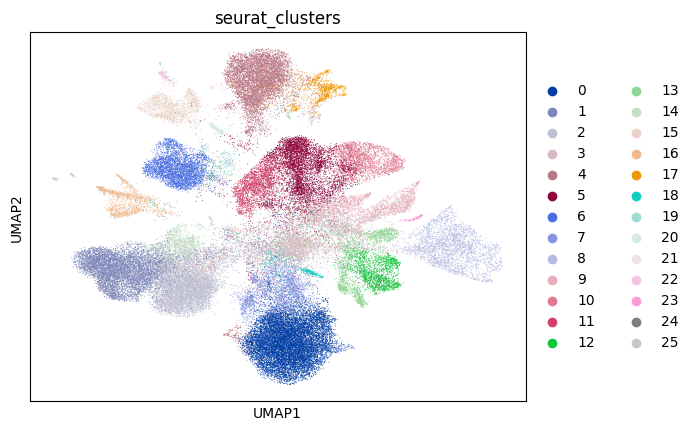

In [98]:
sc.pl.umap(train_data, color=['seurat_clusters'] )

In [60]:
#adipose_sn_ad_sp2.write_h5ad("/home/syyang/GitRepo/cs294/finalproject/script/adipose_with_VAE20270427.h5ad")

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


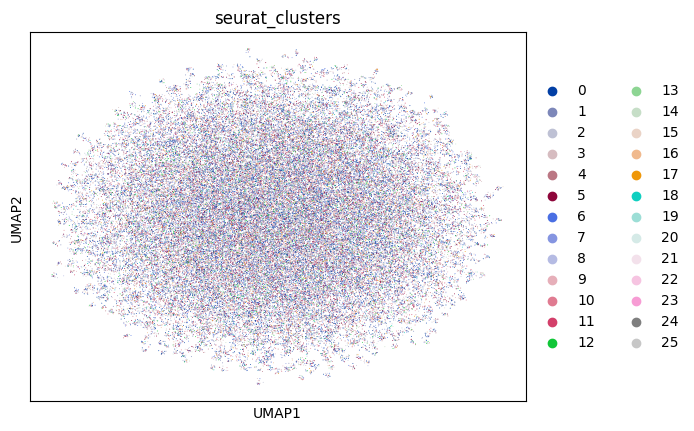

In [34]:
sc.pl.umap(adipose_sn_ad_sp2, color=['seurat_clusters'] )